**Word Level LSTM for trigrams** (sequence length: 2):

This model predicts a word given two prior words. The code broadly consists of three parts:

*   Training the LSTM model and save it to a file.
*   Load the model from the file.
*   Calculate the accuracy of the model based on the frequency-based N-gram (trigram in this case) counts.

Pros:
- Offers less sparsity and shorter sequence lengths in contrast to character-level alternatives.
- No post-processing required.
- Model trained on sequence length of n-words works well for all values less than n.
- Good at capturing long-distance dependencies.

Cons:
- They are unable to generate a word which is unseen/rare during training, hence, suffer from the Out-Of-Vocabulary (OOV) problem. One solution is to have a large dictionary, but still, that increases the time and space complexity of the network and also, the same problem would appear for every new word.
- Softmax used in the output layer is often computationaly intensive.
- Harder to model languages with a rich morphology such as Finish, Turkish, Russian etc..

In [1]:
from google.colab import drive
drive.mount("/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
cd ../gdrive/My\ Drive/NLP/Project/Final\ Project/LSTM/

/gdrive/My Drive/NLP/Project/Final Project/LSTM


In [3]:
ls

'10 letters window 10 epochs of LSTM Next word Prediction.ipynb'
'10 letters window 30 epochs of LSTM Next word Prediction.ipynb'
 checkpoints/
 data.txt
 examples.txt
'LSTM Next word Prediction.ipynb'
 lstm_train.py
 model.h5
 pima_indians.txt
 republic.txt
 requirements.txt
 tokenizer.pkl
 trigram_model.png
 vocabulary.txt
'Word Level LSTM.ipynb'


In [0]:
!pip install tensorflow-gpu==1.14

In [0]:
from numpy import array
from pickle import dump
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

In [0]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

# load dataset
in_filename = 'republic.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')

# integer encode sequences of words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)
# vocabulary size
vocab_size = len(tokenizer.word_index) + 1

In [6]:
sequences[1:10]

[[],
 [30, 1614, 5, 26, 1, 163, 2, 2549, 2550, 35, 44, 2871, 3, 28],
 [568, 44, 3940, 4907, 21, 37, 1062, 73, 235, 73, 248, 13],
 [2551, 163, 73, 157, 1, 379, 2, 1, 286, 264, 1178, 1325],
 [28, 30, 1614, 13, 3323, 35, 2552, 264, 1404],
 [],
 [],
 [2069, 1, 227],
 []]

In [0]:
flat_list = [item for sublist in sequences for item in sublist]

In [0]:
# prepare the dataset of input to output pairs encoded as integers
seq_length = 2
dataX = []
dataY = []
for i in range(0, len(flat_list) - seq_length, 1):
	seq_in = flat_list[i:i + seq_length]
	seq_out = flat_list[i + seq_length]
	dataX.append(seq_in)
	dataY.append(seq_out)
n_patterns = len(dataX)

In [0]:
dataX = array(dataX)
dataY = array(dataY)

In [10]:
dataX.shape, dataY.shape

((221275, 2), (221275,))

In [11]:
# separate into input and output
X, y = dataX, dataY
y = to_categorical(y, num_classes=vocab_size)
seq_length = dataX.shape[1]

# define model
model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=seq_length))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(100, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))
print(model.summary())
# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit model
model.fit(X, y, batch_size=128, epochs=50)

# save the model to file
model.save('model.h5')
# save the tokenizer
dump(tokenizer, open('tokenizer.pkl', 'wb'))




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2, 50)             551800    
_________________________________________________________________
lstm_1 (LSTM)                (None, 2, 100)            60400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 11036)             1114636   
Total params: 1,817,336
Trainable params: 1,817,336
Non-trainable params: 0
_________________________________________________________________
None


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epo

In [0]:
from random import randint
from pickle import load
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model
import nltk
from nltk.util import ngrams
import collections

In [0]:
# load the model for predictions. Note that this code can be run separately in a different environment (provided we have the model files).
model = load_model('model.h5')

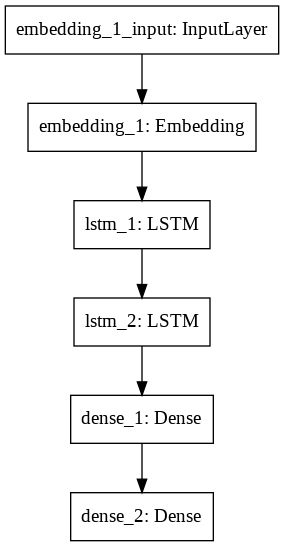

In [14]:
plot_model(model, to_file="trigram_model.png") #show_shapes=True,   expand_nested=True

In [0]:
# load the tokenizer
tokenizer = load(open('tokenizer.pkl', 'rb'))

In [0]:
# generate a sequence from a language model
def generate_seq(model, tokenizer, seq_length, seed_text, n_words):
	result = list()
	in_text = seed_text
	# generate a fixed number of words
	for _ in range(n_words):
		# encode the text as integer
		encoded = tokenizer.texts_to_sequences([in_text])[0]
		# truncate sequences to a fixed length
		encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
		# predict probabilities for each word
		yhat = model.predict_classes(encoded, verbose=0)
		# map predicted word index to word
		out_word = ''
		for word, index in tokenizer.word_index.items():
			if index == yhat:
				out_word = word
				break
		# append to input
		in_text += ' ' + out_word
		result.append(out_word)
	return ' '.join(result)

In [0]:
# select a seed text
seed_text = "Yes he"

In [21]:
# generate new text
generated = generate_seq(model, tokenizer, 2, seed_text, 1)
print(generated)

said


In [22]:
# code to confirm few n-grams generated by the LSTM model by comparing it with actual frequency based output
blogs = open('republic.txt', 'rt')
text = blogs.read()
blogs.close()
corpus = text
# We will remove double quotes, !, ? $, #, etc
# specify to translate chars 
str1 = ""
# specify to replace with 
str2 = ""
# delete chars 
str3 = "\"!?#$%^&*+"

trg = corpus
table = trg.maketrans(str1, str2, str3)
corpus = trg.translate(table)
words = corpus.split()

esTrigrams = ngrams(words, 3)
esTrigramFreq = collections.Counter(esTrigrams)
esTrigramFreq.most_common(10)

[(('as', 'well', 'as'), 113),
 (('to', 'be', 'the'), 109),
 (('is', 'to', 'be'), 76),
 (('which', 'is', 'the'), 74),
 (('Yes,', 'he', 'said,'), 74),
 (('are', 'to', 'be'), 70),
 (('the', 'nature', 'of'), 68),
 (('the', 'idea', 'of'), 67),
 (('there', 'is', 'no'), 66),
 (('he', 'said.', 'And'), 66)]

In [27]:
# code to test the LSTM generated output with the frequency-based output over 100 predictions.
testSet = esTrigramFreq.most_common(100)
count=0
for trigramTup in testSet:
  trigram=trigramTup[0]
  seed_text=trigram[0]+" "+trigram[1]
  expected_text=trigram[2]
  generated = generate_seq(model, tokenizer, 2, seed_text, 1)
  # print(seed_text+" : "+"("+expected_text+" , "+generated+")")
  if generated.strip()== expected_text:
    count+=1
print ("Accuracy: ",count/100)

Accuracy:  0.75
